# Plot radial analysis

This notebook counts the cumulative spatio-temporal distribution of cellular events in the local neighbourhood of a series of focal events and renders various types of plots to show distributions etc


In [1]:
import calculate_radial_analysis as calculate
import dataio

import glob
import os
import re
from tqdm.auto import tqdm
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from natsort import natsorted
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [464]:
def render(N_events_df, N_cells_df, bins, t_range, R_max):
    """
    Take 2 input dataframes of events and cell apperances and render a ratio plot of the two according to the provided params
    
    N_events_df : pd.DataFrame
        Dataframe showing the cumulative spatiotemporal distribution of cellular events around a series of 
        focal events. For example, the distributions of divisions around focal apoptoses.
        
    N_cells_df : pd.DataFrame
        Corresponding dataframe showing the cumulative spatiotemporal distribution of cells around a series of focal events.
    
    bins : int or tuple
        How to plot the provided data in a 2d histogram. If int then symmetric histogram is plotted.
    
    t_range : int
        Maximum extent of the x axis of the histogram
    
    R_max : int
        Maximum extent of the y axis of the histogram
    
    """
    
    t_min = min(t_range)
    t_max = max(t_range)
    N_events_constrained_df = N_events_df.loc[(N_events_df['Time since apoptosis'] >= t_min) & (N_events_df['Time since apoptosis'] <= t_max) & (N_events_df['Distance from apoptosis'] <= R_max)]
    N_cells_constrained_df = N_cells_df.loc[(N_cells_df['Time since apoptosis'] >= t_min) & (N_cells_df['Time since apoptosis'] <= t_max) & (N_cells_df['Distance from apoptosis'] <= R_max)]

    N_events, xedges, yedges, _ = plt.hist2d(N_events_constrained_df['Time since apoptosis'], N_events_constrained_df['Distance from apoptosis'],
                      bins=bins, cmap='Blues')
    plt.clf()
    N_cells, xedges, yedges, _ = plt.hist2d(N_cells_constrained_df['Time since apoptosis'], N_cells_constrained_df['Distance from apoptosis'],
                      bins=bins, cmap='Blues')
    plt.clf()
    
    P_events = N_events/N_cells
    
    return P_events, xedges, yedges, N_events, N_cells

def load_radial_df(file_list, limit = None, crop_amount = 20, streamline = True, strict_filtering = False):
    """
    Function to load and compile a series of radial scans into a larger cumulative dataframe.
    Can provide various criterion to filter the data sets by. 
    I'm sure this code is messy in the latter parts but i do not have time to tidy rn!!!!!!
    
    file_list : list of paths
        List of full paths to the .csv files containing the focal scan results
        
    limit : int or tuple 
        int of maximum scan radius or tuple of (maximum scan radius, minimum scan duration (frames))
        If int then it defines the maximum radius of a focal scan in pixels, if this radius leaves the field of view 
        then that focal apoptosis is either a) excluded from the cumulative scan (if strict_filtering == True)
        or b) The time points at which is leaves the FOV are excluded (if R is given but strict_filtering == False).
        If tuple then the second value is the minimum time period of any included focal scan. Need to include

    crop_amount : int
        Defines the cropping amount necessary to exclude boundary effect cells/divisions from
        the radial scan

    streamlined : bool
        If True this returns just the distance from apoptosis and time since apoptosis variables 
        in the data frame. If False then it returns data frame as in the .csv file.
        
    strict_filtering : bool
        If True then this means that any focal scans that do not meet the inclusion criteria stipulated in `limit`
        will be entirely dismissed, rather than individual timepoints being dismissed. 
    """
    radial_scan_df = []
    N_focal_cells = 0

    ### if limit is not provided then do not filter any focal apoptoses
    if not limit:
        R = 0
    ### if limit is a tuple then filter according to a maximum radius staying within the fov and a minimum focal scan length
    if type(limit) == tuple:
        T = limit[1] 
        R = limit[0] 
    else:
        T = None
        R = limit
    
    ### define window within which focal cell can exist if there is a spatial limit
    x_range = range(R, 1200 - R)
    y_range = range(R, 1600 - R)    
    
    ### iterate over each individual scan and compile into cumulative pd dataframe    
    for file in tqdm(file_list):
        ### first check to see if focal cell meets inclusion criterion
        if R > 0:
            ### get apoptosis time
            focal_t = int(re.search('txy_(\d+)', file).group(1))
            ### get apop id to load apop xyt file
            apop_ID = file.split('/')[-1].split('_N_')[0]
            ### ensure correct cell type
            if 'Scr' in apop_ID:
                apop_ID = apop_ID.replace('Scr_-','')+'_RFP'
            if 'wt' in apop_ID:
                apop_ID = apop_ID.replace('wt_','')+'_GFP'
            ### load full apo xyt ### need to change this path if im using the typical randomised control
            apo_xyt_fn = os.path.join('/home/nathan/data/kraken/scr/h2b/giulia/experiment_information/apoptoses/apoptotic_tracks',#', #control_event_tracks
                                     f'{apop_ID}.csv')
            ### load focal cell information
            apo_df = pd.read_csv(apo_xyt_fn)
            ### remove unnecessary index column
            del apo_df['Unnamed: 0']
            ### see if any of the frames of the focal cell leave the FOV
            frames_outside_fov = []
            for apo_x, apo_y, apo_t in zip(apo_df['x'], apo_df['y'], apo_df['t']):
                if int(apo_x) not in x_range or int(apo_y) not in  y_range:
                    frames_outside_fov.append(apo_t)
            ### if filtering is strict then exclude any focal cell that leves fov
            if strict_filtering == True:
                if len(frames_outside_fov) > 0:
                    continue
                ### if filtering is strict and there are no frames outside of the fov then exclude if temporal criterion isnt met
                elif T:
                    if focal_t - min(apo_df['t']) < T:
                        continue
        ### if filtering is present but not strict then just exclude time points outside fov
        apo_t, apo_x, apo_y = [int(re.search('txy_(\d+)_(\d+)_(\d+)', file)[i]) for i in range(1,4)]
        ### load dataframe
        df = pd.read_csv(file, names = ['Cell ID', 'Distance from apoptosis', 'Frame', 'x', 'y'])
        ### tidy up dataframe
        df['Cell ID'] = df['Cell ID'].str.replace('[()]', '')
        df['y'] = df['y'].str.replace('[()]', '')
        df = df.astype(int)
        ### normalise time
        df['Time since apoptosis'] = df['Frame'] - apo_t
        ### eliminate boundary counts spatially
        df = df.loc[(df['x'] >= crop_amount) & (df['x'] <= 1200-crop_amount) & (df['y'] >= crop_amount) & (df['y'] <= 1600-crop_amount)]
        ### eliminate boundary effects temporally (ie. if scan exits fov at any time point) by deleting those frames from the scan
        if R > 0: 
            df = df[~df['Frame'].isin(frames_outside_fov)]
        ### remove unnecessary data
        if streamline:
            del df['x'], df['y'], df['Cell ID'], df['Frame']
        radial_scan_df.append(df)
        N_focal_cells +=1
    radial_scan_df = pd.concat(radial_scan_df, axis = 0, ignore_index = True)
    radial_scan_df['Time since apoptosis'] = radial_scan_df['Time since apoptosis']*(4/60)
    radial_scan_df['Distance from apoptosis'] = radial_scan_df['Distance from apoptosis']/3
    print('Number of focal cells included in cumulative scan:', N_focal_cells)
    
    return radial_scan_df

# Compile individual scans into cumulative dataframes 

In [413]:
scan_dir = f'/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600'

In [414]:
files = natsorted(glob.glob(f'{scan_dir}/*.csv'))
event_files = [file for file in files if 'N_events' in file]

In [415]:
event_files

['/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos4_Scr_-6_N_events_wt_rad_1600_t_range_1600_focal_txy_469_692_922.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos4_Scr_-70_N_events_wt_rad_1600_t_range_1600_focal_txy_820_1086_1043.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos4_Scr_-73_N_events_wt_rad_1600_t_range_1600_focal_txy_773_1123_1247.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos5_Scr_-283_N_events_wt_rad_1600_t_range_1600_focal_txy_913_1085_289.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos5_Scr_-298_N_events_wt_rad_1600_t_range_1600_focal_txy_568_404_1103.csv',
 '/home/nathan/data/results/radial_analysis

### Additional params stipulate whether to filter focal scans

In [419]:
N_events_df = load_radial_df(event_files,#) ## no filtering 
                                    limit = (300, 150),
                             crop_amount = 20, ### how much to crop the spatial measurements to avoid boundary effects
                             streamline = False, 
                            strict_filtering=True)

  0%|          | 0/1839 [00:00<?, ?it/s]

Number of focal cells included in cumulative scan: 270


In [341]:
N_events_df

,Cell ID,Distance from apoptosis,Frame,x,y,Time since apoptosis
0,23,124.666667,322,569,1311,-9.800000
1,22,122.666667,576,420,673,7.133333
2,21,79.666667,371,486,784,-6.533333
3,20,315.000000,324,391,46,-9.666667
4,19,134.333333,376,416,622,-6.200000
...,...,...,...,...,...,...
147919,1262,154.666667,1036,949,1504,3.533333
147920,1276,272.000000,967,20,1157,-1.066667
147921,1313,109.000000,1033,1107,878,3.333333
147922,1393,235.333333,990,340,1563,0.466667


### Loading cell counts for probability plot

Has to be streamlined for full list

In [420]:
cell_count_files = [file for file in files if 'N_cell' in file]

In [421]:
cell_count_files

['/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos4_Scr_-6_N_cells_wt_rad_1600_t_range_1600_focal_txy_469_692_922.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos4_Scr_-70_N_cells_wt_rad_1600_t_range_1600_focal_txy_820_1086_1043.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos4_Scr_-73_N_cells_wt_rad_1600_t_range_1600_focal_txy_773_1123_1247.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos5_Scr_-283_N_cells_wt_rad_1600_t_range_1600_focal_txy_913_1085_289.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos5_Scr_-298_N_cells_wt_rad_1600_t_range_1600_focal_txy_568_404_1103.csv',
 '/home/nathan/data/results/radial_analysis_outp

In [422]:
N_cells_df = load_radial_df(cell_count_files,# ) #no filtering
                                    limit = (300, 150),
                             crop_amount = 20, ### how much to crop the spatial measurements to avoid boundary effects
                             streamline = False, 
                            strict_filtering=True)

  0%|          | 0/1839 [00:00<?, ?it/s]

Number of focal cells included in cumulative scan: 270


In [312]:
N_cells_df

,Distance from apoptosis,Time since apoptosis
0,359.666667,-31.266667
1,358.666667,-31.266667
2,157.666667,-31.266667
3,103.333333,-31.266667
4,110.333333,-31.266667
...,...,...
153909557,329.000000,3.733333
153909558,269.333333,3.733333
153909559,292.666667,3.733333
153909560,400.666667,3.733333


# Plotting the spatiotemporal distribution ratio of events to appearances 

`P_events = N_events/N_cells`

Text(0.5, 0, 'Time since apoptoses (hours)')

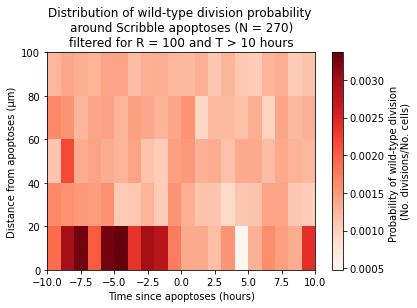

In [458]:
t_range = (-10,10)
R_max = 100
bins = (20, 5)
P_events, xedges, yedges, N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
pc = plt.pcolormesh(xedges, yedges, P_events.T, cmap = 'Reds', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround Scribble apoptoses (N = 270)\nfiltered for R = 100 and T > 10 hours')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
#plt.savefig('', bbox_inches = 'tight')

# Control measures

### 1. Wild-type divisions around random wild-type points

I have some skepticism about this method as it seems too randomised, leading it to pick up some potential boundary effects of scanning in space and time, i.e. it's suspicious that the peaks in probability are repeated in near pre-apoptotic time.

### 2. Wild-type divisions around wild-type apoptoses

Processed

### 3. Wild-type divisions around Scr. apoptoses in uninduced experiments

Need to find Scr. apoptoses in uninduced experiments.

# Loading control measure #1

In [435]:
scan_dir = f'/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/wt_control_wt_div_xyt/1600.1600'

In [436]:
files = natsorted(glob.glob(f'{scan_dir}/*.csv'))
event_files = [file for file in files if 'N_events' in file]
cell_count_files = [file for file in files if 'N_cells' in file]

In [437]:
len(event_files)

7689

#### temp note: need to change path in function if using typical control

In [438]:
control_N_event_df = load_radial_df(event_files[0:3500],
                                    limit = (300, 150),
                                    crop_amount = 20, 
                                    streamline = True, 
                                   strict_filtering= True) ### N_cells is large so streamlining advised

  0%|          | 0/3500 [00:00<?, ?it/s]

Number of focal cells included in cumulative scan: 248


In [439]:
control_N_cell_df = load_radial_df(cell_count_files[0:3500],# ) #no filtering
                                    limit = (300, 150),
                            crop_amount = 20, 
                            streamline = True, 
                           strict_filtering= True) ### N_cells is large so streamlining advised

  0%|          | 0/3500 [00:00<?, ?it/s]

Number of focal cells included in cumulative scan: 248


#### Plotting control #1

Text(0.5, 0, 'Time since apoptoses (hours)')

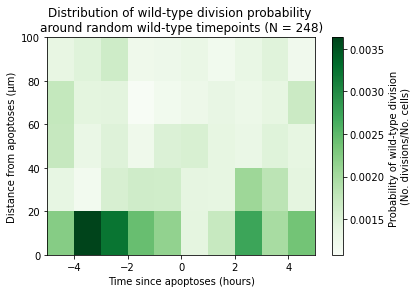

In [440]:
t_range = (-5,5)
R_max = 100
bins = (10, 5)
P_events_c, xedges, yedges,  N_events, N_cells = render(control_N_event_df, control_N_cell_df, bins, t_range, R_max)
pc = plt.pcolormesh(xedges, yedges, P_events_c.T, cmap = 'Greens', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround random wild-type timepoints (N = 248)')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')


#### Plotting probability above background for control #1

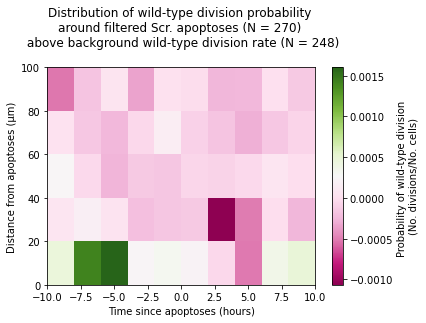

In [441]:
t_range = (-10,10)
R_max = 100
bins = (10, 5)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_N_event_df, control_N_cell_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'PiYG', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround filtered Scr. apoptoses (N = 270) \n above background wild-type division rate (N = 248)\n')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/strict_filtering_300_T>10hr//Difference in probability scr_apop_wt_div wt_control_wt_div cropped 0-100um -10-10hrs.pdf', bbox_inches = 'tight')

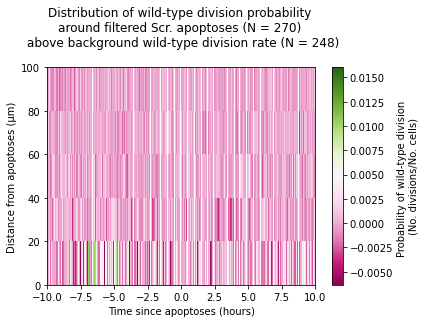

In [442]:
t_range = (-10,10)
R_max = 100
bins = (300, 5)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_N_event_df, control_N_cell_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'PiYG', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround filtered Scr. apoptoses (N = 270) \n above background wild-type division rate (N = 248)\n')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/strict_filtering_300_T>10hr/Difference in probability scr_apop_wt_div wt_control_wt_div cropped 0-100um -10-10hrs fine grained in time.pdf')

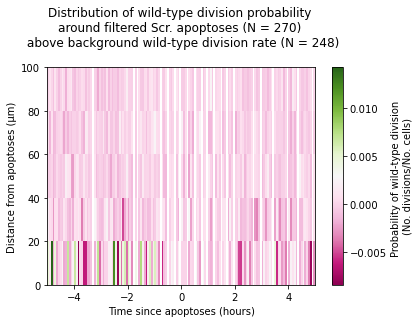

In [443]:
t_range = (-5,5)
R_max = 100
bins = (150, 5)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_N_event_df, control_N_cell_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'PiYG', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround filtered Scr. apoptoses (N = 270) \n above background wild-type division rate (N = 248)\n')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/strict_filtering_300_T>10hr//Difference in probability scr_apop_wt_div wt_control_wt_div cropped 0-100um -5-5hrs finely grained in time.pdf')

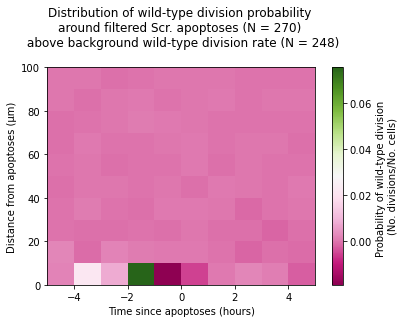

In [444]:
t_range = (-5,5)
R_max = 100
bins = (10, 10)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_N_event_df, control_N_cell_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'PiYG', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround filtered Scr. apoptoses (N = 270) \n above background wild-type division rate (N = 248)\n ')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/strict_filtering_300_T>10hr//Difference in probability scr_apop_wt_div wt_control_wt_div cropped 0-100um -5-5hrs coarsely grained.pdf')

# Control measure #2 

### Wild-type divisions around wild-type apoptoses

In [446]:
control_2_file_path = '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/wt_apop_wt_div_xyt/1600.1600'

In [447]:
files = natsorted(glob.glob(f'{control_2_file_path}/*.csv'))
event_files = [file for file in files if 'N_events' in file]
cell_count_files = [file for file in files if 'N_cells' in file]

In [451]:
len(event_files)

385

In [449]:
event_files

['/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/wt_apop_wt_div_xyt/1600.1600/GV0794_Pos3_wt_142_N_events_wt_rad_1600_t_range_1600_focal_txy_811_447_825.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/wt_apop_wt_div_xyt/1600.1600/GV0794_Pos3_wt_311_N_events_wt_rad_1600_t_range_1600_focal_txy_731_259_1096.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/wt_apop_wt_div_xyt/1600.1600/GV0794_Pos4_wt_393_N_events_wt_rad_1600_t_range_1600_focal_txy_766_1173_1456.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/wt_apop_wt_div_xyt/1600.1600/GV0794_Pos5_wt_1_N_events_wt_rad_1600_t_range_1600_focal_txy_35_274_1395.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/wt_apop_wt_div_xyt/1600.1600/GV0794_Pos7_wt_292_N_events_wt_rad_1600_t_range_1600_focal_txy_884_447_1576.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/

In [465]:
control_2_N_events_df = load_radial_df(event_files,# ) #no filtering
                                    limit = 300,# 150),
                            crop_amount = 20, 
                            streamline = True, 
                           strict_filtering= True) ### N_cells is large so streamlining advised
control_2_N_cells_df = load_radial_df(cell_count_files,# ) #no filtering
                                    limit = 300,# 150),
                            crop_amount = 20, 
                            streamline = True, 
                           strict_filtering= True) ### N_cells is large so streamlining advised

  0%|          | 0/385 [00:00<?, ?it/s]

Number of focal cells included in cumulative scan: 105


  0%|          | 0/385 [00:00<?, ?it/s]

Number of focal cells included in cumulative scan: 105


#### Plotting control #2

# need to replot this as unfiltered in time 300 radius

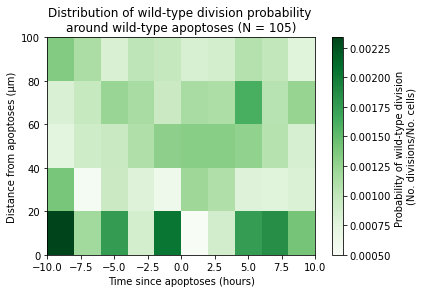

In [467]:
t_range = (-10,10)
R_max = 100
bins = (10, 5)
P_events_c, xedges, yedges,  N_events, N_cells = render(control_2_N_events_df, control_2_N_cells_df, bins, t_range, R_max)
pc = plt.pcolormesh(xedges, yedges, P_events_c.T, cmap = 'Greens', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround wild-type apoptoses (N = 51)')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
#plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/strict_filtering_300_T>10hr/wt_apop_wt_div probability cropped 0-100um -10-10hrs.pdf')

#### Plotting probability above background for control #2

Text(0.5, 0, 'Time since apoptoses (hours)')

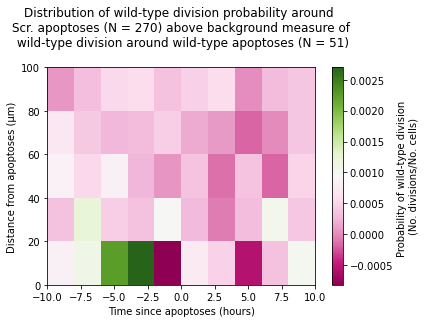

In [459]:
t_range = (-10,10)
R_max = 100
bins = (10, 5)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_2_N_events_df, control_2_N_cells_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'PiYG', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability around \nScr. apoptoses (N = 270) above background measure of\n wild-type division around wild-type apoptoses (N = 51)\n ')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
#plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/strict_filtering_300_T>10hr//Difference in probability scr_apop_wt_div wt_apop_wt_div cropped 0-100um -10-10hrs.pdf', bbox_inches = 'tight')

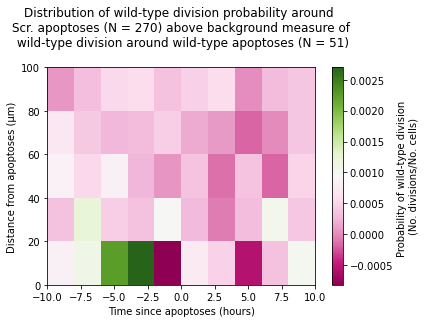

In [460]:
t_range = (-10,10)
R_max = 100
bins = (10, 5)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_2_N_events_df, control_2_N_cells_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'PiYG', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability around \nScr. apoptoses (N = 270) above background measure of\n wild-type division around wild-type apoptoses (N = 51)\n ')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/strict_filtering_300_T>10hr//Difference in probability scr_apop_wt_div wt_apop_wt_div cropped 0-100um -10-10hrs.pdf', bbox_inches = 'tight')

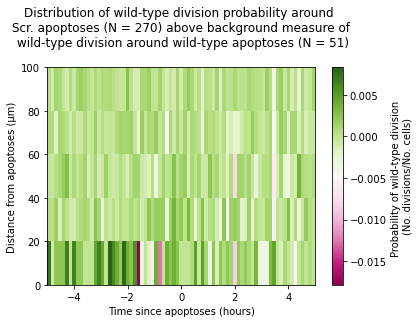

In [461]:
t_range = (-5,5)
R_max = 100
bins = (75,5)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_2_N_events_df, control_2_N_cells_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'PiYG', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability around \nScr. apoptoses (N = 270) above background measure of\n wild-type division around wild-type apoptoses (N = 51)\n ')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/strict_filtering_300_T>10hr//Difference in probability scr_apop_wt_div wt_apop_wt_div cropped 0-100um -5-5hrs finely grained in time.pdf', bbox_inches = 'tight')

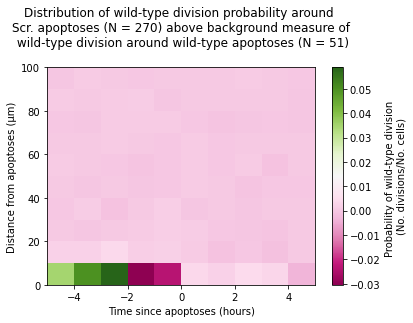

In [462]:
t_range = (-5,5)
R_max = 100
bins = (10,10)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_2_N_events_df, control_2_N_cells_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'PiYG', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability around \nScr. apoptoses (N = 270) above background measure of\n wild-type division around wild-type apoptoses (N = 51)\n ')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/strict_filtering_300_T>10hr//Difference in probability scr_apop_wt_div wt_apop_wt_div cropped 0-100um -5-5hrs coarse grained.pdf', bbox_inches = 'tight')

# Sandbox

Text(0.5, 0, 'Time since apoptoses (hours)')

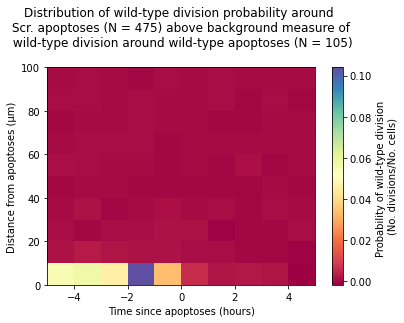

In [135]:
t_range = (-5,5)
R_max = 100
bins = (10,10)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_2_N_events_df, control_2_N_cells_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'Spectral', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability around \nScr. apoptoses (N = 475) above background measure of\n wild-type division around wild-type apoptoses (N = 105)\n ')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')